# Installation of Necessary Libraries

In [8]:
# Install necessary libraries that are not pre-installed in Google Colab
!pip install pyswarms
!pip install imbalanced-learn

#  Import Libraries

In [20]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
import pyswarms as ps
from pyswarms.utils.plotters import plot_cost_history

#Load and Preprocess the Data

In [10]:
# Load the data
df = pd.read_csv('/content/creditcard.csv', low_memory=False)
# Drop unnecessary columns
df = df.drop(['Time', 'Amount'], axis=1)
# Define features and target
X = df.iloc[:, :-1]
y = df['Class']
# Display first few rows of the dataframe
df.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0.0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.0


#Preprocess Data (Handle NaNs in Features and Target)

In [15]:
# Impute missing values in features
imputer_X = SimpleImputer(strategy='mean')
X_imputed = imputer_X.fit_transform(X)  # Impute any missing values in features

# Check and handle any missing values in the target
if y.isnull().any():
    y = y.fillna(y.mode()[0])  # Fill NaNs with the mode (most frequent value) in target if any

# After handling NaNs, apply scaling and PCA

data_scaled = scale(X_imputed)
pca = PCA(n_components=10)
X_pca = pca.fit_transform(data_scaled)

# Output the transformed features and target type
print(X_pca)
print(y)
print(type(X_pca))

[[-0.22674224 -0.89838395 -0.83629053 ...  0.16933562  0.02553671
   0.69393709]
 [ 0.06849503 -0.3107936   0.66414871 ... -0.14148547  0.10007135
  -0.00942423]
 [-0.21170502 -1.0067286  -1.91572763 ...  0.03583506 -1.03561554
   1.35338394]
 ...
 [-0.14188597 -0.59032598  1.74508017 ...  0.30106197  0.65943921
  -0.02991291]
 [ 0.17301823  0.4639528  -2.28274853 ... -0.21114489 -0.64777125
   0.83383477]
 [-0.03416071 -0.04896508  0.25804403 ... -0.10541087 -0.16571844
   0.2296465 ]]
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
65448    0.0
65449    0.0
65450    0.0
65451    0.0
65452    0.0
Name: Class, Length: 65453, dtype: float64
<class 'numpy.ndarray'>


#Split Data and Apply SMOTE

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.33, random_state=42)

# Apply SMOTE for handling class imbalance in the training set
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Convert resampled data back to DataFrame for compatibility with further operations
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=[f'PCA_{i}' for i in range(X_train_resampled.shape[1])])
y_train_resampled_df = pd.Series(y_train_resampled)

# Output to verify
print("Resampled X shape:", X_train_resampled_df.shape)
print("Resampled y shape:", y_train_resampled_df.shape)

Resampled X shape: (87482, 10)
Resampled y shape: (87482,)


#Define Neural Network and PSO Functions

In [18]:
def forward_prop(params):
    # Neural network parameters
    n_inputs, n_hidden, n_classes = 10, 20, 2
    W1 = params[:200].reshape((n_inputs, n_hidden))
    b1 = params[200:220].reshape((n_hidden,))
    W2 = params[220:260].reshape((n_hidden, n_classes))
    b2 = params[260:262].reshape((n_classes,))

    # Forward propagation
    z1 = X_train_resampled.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    logits = z2
    exp_scores = np.exp(logits)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Compute loss
    N = X_train_resampled.shape[0]
    correct_logprobs = -np.log(probs[range(N), y_train_resampled.astype(int)])
    loss = np.sum(correct_logprobs) / N
    return loss

def f(x):
    n_particles = x.shape[0]
    return np.array([forward_prop(x[i]) for i in range(n_particles)])

# Configure and run PSO
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
dimensions = 262
optimizer = ps.single.GlobalBestPSO(n_particles=50, dimensions=dimensions, options=options)
cost, pos = optimizer.optimize(f, iters=150, verbose=3)

2024-04-17 06:50:36,466 - pyswarms.single.global_best - INFO - Optimize for 150 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|150/150, best_cost=0.0363
2024-04-17 07:12:46,907 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.03634699281843294, best pos: [ 1.18231861e-01 -1.16013730e-01  4.53099646e-02 -1.34797599e-01
 -2.68447327e-01  8.08375491e-01  1.46797197e+00  1.19440369e+00
 -4.84479904e-01 -2.87124851e-01  9.46769896e-01  4.96584573e-02
  1.38876702e+00  6.71360349e-01  9.14106591e-01  1.21158587e+00
  1.03936245e+00  2.36002350e+00 -8.87214426e-01  3.68872149e-01
 -5.12279107e-01  4.24833524e-01  5.90248089e-01  3.43833203e-01
  3.42522895e-01  2.32599865e+00  1.48772015e+00 -3.50107689e-01
  4.83650823e-01 -6.57013537e-02 -2.17129789e-01  3.96545131e-01
 -9.66652356e-03  7.28064559e-01  5.19627689e-02 -9.98324017e-02
  1.19198317e+00  2.53292744e-01  1.02527493e+00 -2.67381771e+00
  1.00776358e+00 -1.005876

#Plot Optimization History and Make Predictions

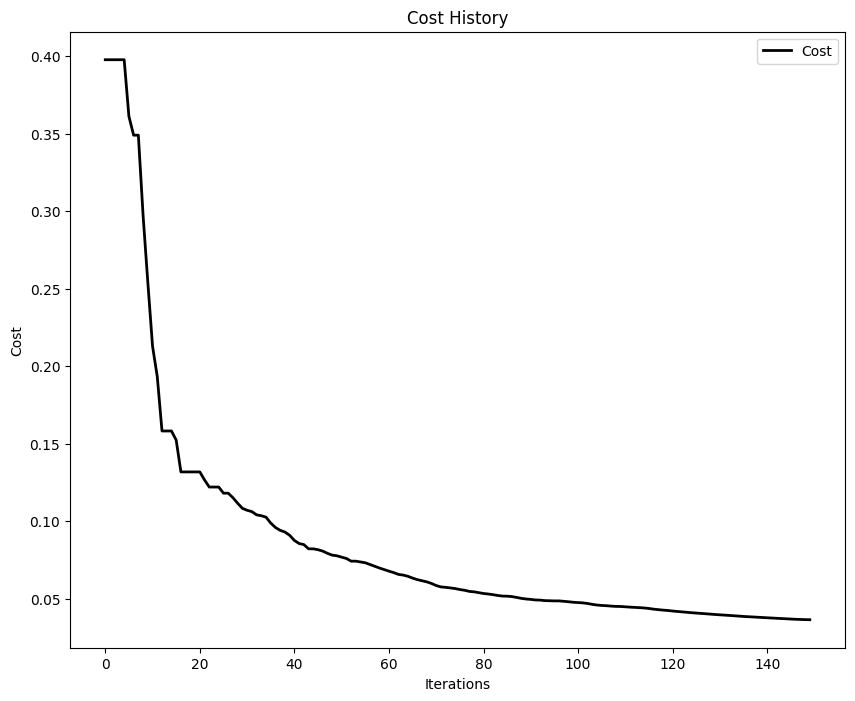

Prediction accuracy: 0.9888425925925926


In [21]:
# Plot cost history

plot_cost_history(cost_history=optimizer.cost_history)
plt.show()

# Define prediction function using trained positions
def predict(X, pos):
    n_inputs, n_hidden, n_classes = 10, 20, 2
    W1 = pos[:200].reshape((n_inputs, n_hidden))
    b1 = pos[200:220].reshape((n_hidden,))
    W2 = pos[220:260].reshape((n_hidden, n_classes))
    b2 = pos[260:262].reshape((n_classes,))

    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    logits = z2
    y_pred = np.argmax(logits, axis=1)
    return y_pred

# Evaluate accuracy
accuracy = (predict(X_test, pos) == y_test).mean()
print(f"Prediction accuracy: {accuracy}")
